力とエネルギーのみで学習を行ったモデルを使って、アモルファス状態でVirialがどの程度合致するかをテストする

In [1]:
from ase.calculators.calculator import Calculator, all_changes
import torch

from simplegnn.preprocess import RadiusInteractionGraph
from torch_geometric.data import Data
from torch.autograd.functional import hessian
from torch_scatter import scatter_add

def converter(atoms, cutoff):
    x = torch.tensor(atoms.numbers, dtype=torch.long)

    # 近傍情報の取得
    edge_index, edge_weight = RadiusInteractionGraph(atoms, cutoff)

    # ノードの3次元座標
    pos = torch.tensor(atoms.positions, dtype=torch.float32)

    # PyG Dataオブジェクトを構築
    data = Data(x=x, edge_index=edge_index,edge_weight=edge_weight, pos=pos)

    return data

class SchNetCalculator(Calculator):
    implemented_properties = ['energy', 'forces']

    def __init__(self, model, cutoff, device='cpu'):
        Calculator.__init__(self)
        self.model = model.to(device)
        self.cutoff = cutoff
        self.device = device

    def calculate(self, atoms=None, properties=['energy'],
                  system_changes=all_changes):
        
        if self.calculation_required(atoms, properties):
            self.results = {}
            data = converter(atoms, self.cutoff)
            data=data.to(self.device)
            data.edge_weight.requires_grad = True

            energy = self.model(data.x, data.edge_index, data.edge_weight)

            diff_ij = torch.autograd.grad(energy, data.edge_weight)[0]
            force_i = torch.zeros((len(data.x), 3), device=self.device)
            force_j = torch.zeros((len(data.x), 3), device=self.device)
            force_i.index_add_(0, data.edge_index[0], diff_ij)
            force_j.index_add_(0, data.edge_index[1], -diff_ij)
            force = force_i + force_j
            self.results['energy'] = energy.to('cpu').item()
            self.results['forces'] = force.to('cpu').detach().numpy()

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import pi as PI
import numpy as np

def scatter(src, index, dim=0, dim_size=None, reduce="add"):
    if reduce not in ("add", "sum"):
        raise NotImplementedError("reduce only supports add/sum in fallback")
    out_shape = list(src.shape)
    if dim_size is None:
        dim_size = int(index.max().item()) + 1 if index.numel() > 0 else 0
    out_shape[dim] = dim_size
    out = torch.zeros(out_shape, dtype=src.dtype, device=src.device)
    out.index_add_(dim, index, src)
    return out

# ==============================================================
# ガウス基底関数の計算 (RBF)
# ==============================================================
def gaussian_rbf(inputs, offsets, widths):
    coeff = -0.5 / widths**2
    diff = inputs[..., None] - offsets
    return torch.exp(coeff * diff**2)

class GaussianRBF(nn.Module):
    def __init__(self, n_rbf, cutoff, start=0.0):
        super().__init__()
        self.register_buffer("offsets", torch.linspace(start, cutoff, n_rbf))
        self.register_buffer("widths", torch.full((n_rbf,), cutoff / n_rbf))

    def forward(self, distances):
        return gaussian_rbf(distances, self.offsets, self.widths)

# ==============================================================
# カットオフ関数
# ==============================================================
def cutoff_function(distances, cutoff):
    C = 0.5 * (torch.cos(distances * PI / cutoff) + 1.0)
    C[distances > cutoff] = 0.0
    return C

# ==============================================================
# 原子種を埋め込みベクトルに変換
# ==============================================================
class TypeEmbedding(nn.Module):
    def __init__(self, type_num, type_dim):
        super().__init__()
        self.embedding = nn.Embedding(type_num, type_dim)

    def forward(self, x):
        return self.embedding(x)
    
class ShiftedSoftplus(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return F.softplus(x) - torch.log(torch.tensor(2.0, device=x.device))


# ==============================================================
# 相互作用ブロック (Interaction Block)
class InteractionBlock(nn.Module):
    def __init__(self, hidden_dim, num_gaussians, num_filters, cutoff):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(num_gaussians, num_filters),
            ShiftedSoftplus(),
            nn.Linear(num_filters, num_filters),
        )
        self.cutoff = cutoff
        self.lin1 = nn.Linear(hidden_dim, num_filters, bias=False)
        self.lin2 = nn.Linear(num_filters, hidden_dim)
        self.act = ShiftedSoftplus()

    def forward(self, x, edge_index, edge_weight, edge_attr):

        # 原子間距離の計算
        distances = torch.norm(edge_weight, dim=-1)  # 原子間距離 (num_edges,)
        C = cutoff_function(distances, self.cutoff)  # カットオフ関数 (num_edges,)
        
        # フィルター重みの計算
        W = self.mlp(edge_attr) * C.unsqueeze(-1)  # (num_edges, num_filters)

        # メッセージ生成
        i, j = edge_index  # edge_index (2, num_edges)
        messages = W * self.lin1(x[j])  # (num_edges, num_filters)

        #print("messages:",messages.shape)
        #print("x:",x.shape)

        # メッセージ集約
        #index_addの利用を避ける（indexが同じものがあるケースだと問題がある）
        agg_messages = torch.zeros_like(self.lin1(x))
        # scatter_addが入った状態でgradが通るように、行列形状を調整している
        index = i.unsqueeze(1) if i.ndim == 1 else index
        agg_messages = torch.scatter_add(agg_messages, 0, index.expand_as(messages), messages)

        #print("agg_messages:",agg_messages.shape)
        # 特徴量更新
        h = self.act(self.lin2(agg_messages))  # 非線形変換を適用
        #print("h:",h.shape)
        return x + h


class SchNet_dict():
    def __init__(self, hidden_dim, num_gaussians, num_filters, num_interactions, cutoff, type_num=100):
        self.hidden_dim = hidden_dim
        self.num_gaussians = num_gaussians
        self.num_filters = num_filters
        self.num_interactions = num_interactions
        self.cutoff = cutoff
        self.type_num = type_num

    def to_dict(self):
        return {
            "hidden_dim": self.hidden_dim,
            "num_gaussians": self.num_gaussians,
            "num_filters": self.num_filters,
            "num_interactions": self.num_interactions,
            "cutoff": self.cutoff,
            "type_num": self.type_num
        }

    @classmethod
    def from_dict(cls, dic):
        return cls(**dic)
    
class SchNetModel(nn.Module):


    def __init__(self, hidden_dim, num_gaussians, num_filters, num_interactions, cutoff, type_num=100):
        super().__init__()

        self.setups=SchNet_dict(hidden_dim, num_gaussians, num_filters, num_interactions, cutoff, type_num)
        self.embedding = TypeEmbedding(type_num, hidden_dim)
        self.rbf = GaussianRBF(num_gaussians, cutoff)
        self.interactions = nn.ModuleList()
        for _ in range(num_interactions):
            block = InteractionBlock(hidden_dim, num_gaussians,
                                     num_filters, cutoff)
            self.interactions.append(block)
        self.output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            ShiftedSoftplus(),
            nn.Linear(hidden_dim // 2, 1)
        )
        #initialize weights
        #pytorch のデフォルト初期化で十分であった（下手にいじると収束しにくくなる）
        #self.apply(initialize_weights)

    def forward(self, x, edge_index, edge_weight, batch=None):
        #力を計算したいので、edge_weight (Rj-Ri)の微分を取る
        edge_weight.requires_grad_()
        # 埋め込み
        h = self.embedding(x)

        #print("embedding:",h.shape)

        # RBF展開
        distances = torch.norm(edge_weight, dim=-1)
        rbf_expansion = self.rbf(distances)
        #print("rbf:",rbf_expansion.shape)

        # 相互作用ブロックを適用
        for interaction in self.interactions:
            h = interaction(h, edge_index, edge_weight, rbf_expansion)

        # 出力層
        energy = self.output(h)

        # derivative with respect to edge_weight=rj-ri
        diff_E = torch.autograd.grad(energy.sum(), edge_weight, create_graph=True)[0]
        #p: pair, k,l: x,y,z
        sigma_ij = torch.einsum('pk,pl->pkl', edge_weight, diff_E)


        #edge_weightはrj-riである。
        #ここでdeviceに指定していないと、CPUで計算されてしまう
        force_i = torch.zeros((len(x), 3), device=edge_weight.device)
        force_j = torch.zeros((len(x), 3), device=edge_weight.device)

        #scatter_add version (index_addだとindexが同じものがあるケースだと問題があるかも)
        index_i=edge_index[0].unsqueeze(1) if edge_index[0].ndim == 1 else edge_index[0]
        index_j=edge_index[1].unsqueeze(1) if edge_index[1].ndim == 1 else edge_index[1]
        force_i=torch.scatter_add(force_i, 0, index_i.expand_as(diff_E), diff_E)
        force_j=torch.scatter_add(force_j, 0, index_j.expand_as(diff_E), -diff_E)

        forces=force_i+force_j

        # バッチごとに集約


        if batch is not None:
            batch_max = batch.max().item()
            total_energy = torch.zeros(batch_max + 1, device=energy.device)
            total_energy = total_energy.index_add_(0, batch, energy.squeeze())

            sigma = torch.zeros((batch_max + 1, 3, 3), device=edge_weight.device)
            batch_edge = batch[edge_index[0]]  # edge_indexのi側の原子のバッチ情報
            sigma = sigma.index_add_(0, batch_edge, sigma_ij)

        
        else:
            total_energy = energy.sum()
            sigma = sigma_ij.sum(dim=0)
            
        if sigma.dim() == 3:
            sigma = 0.5 * (sigma + sigma.transpose(1, 2))
        else:
            sigma = 0.5 * (sigma + sigma.T)

        return total_energy,forces,sigma

import torch
import torch.nn as nn


class SchNet_inference(nn.Module):
    def __init__(self, hidden_dim, num_gaussians, num_filters, num_interactions, cutoff, type_num=100):
        super().__init__()
        self.embedding = TypeEmbedding(type_num, hidden_dim)
        self.rbf = GaussianRBF(num_gaussians, cutoff)
        self.interactions = nn.ModuleList()
        for _ in range(num_interactions):
            block = InteractionBlock(hidden_dim, num_gaussians,
                                     num_filters, cutoff)
            self.interactions.append(block)
        self.output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            ShiftedSoftplus(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x, edge_index, edge_weight, batch=None):

        h = self.embedding(x)

        distances = torch.norm(edge_weight, dim=-1)
        rbf_expansion = self.rbf(distances)

        for interaction in self.interactions:
            h = interaction(h, edge_index, edge_weight, rbf_expansion)

        # 出力層
        energy = self.output(h)


        if batch is not None:
            batch_max = batch.max()
            total_energy = torch.zeros(batch_max + 1, device=energy.device)
            total_energy = total_energy.index_add_(0, batch, energy.squeeze())
        else:
            total_energy = energy.sum()
            
        return total_energy



In [3]:
cutoff=5.0
num_gaussians=60
hidden_dim=100
num_interactions=3
num_filters=100

model = SchNetModel(hidden_dim=hidden_dim, num_gaussians=num_gaussians, 
                    num_filters=num_filters, num_interactions=num_interactions, cutoff=cutoff)

In [4]:
model.load_state_dict(torch.load('/home/emi/ML/simpleGNN/simplegnn/schnet_test/pressure_test/model_schnet_torch_full_stepLR.pth', map_location='cpu'))

<All keys matched successfully>

In [5]:
model.eval()

SchNetModel(
  (embedding): TypeEmbedding(
    (embedding): Embedding(100, 100)
  )
  (rbf): GaussianRBF()
  (interactions): ModuleList(
    (0-2): 3 x InteractionBlock(
      (mlp): Sequential(
        (0): Linear(in_features=60, out_features=100, bias=True)
        (1): ShiftedSoftplus()
        (2): Linear(in_features=100, out_features=100, bias=True)
      )
      (lin1): Linear(in_features=100, out_features=100, bias=False)
      (lin2): Linear(in_features=100, out_features=100, bias=True)
      (act): ShiftedSoftplus()
    )
  )
  (output): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ShiftedSoftplus()
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [6]:
from ase.io import read 
atoms = read('/home/emi/ML/simpleGNN/simplegnn/schnet_test/pressure_test/dataset_with_stress_energy_forces.extxyz')
atoms

Atoms(symbols='O140Si70', pbc=True, cell=[12.5, 12.5, 12.5], calculator=SinglePointCalculator(...))

In [7]:
atoms.get_total_energy()

-1398.75429383

In [8]:
atoms.get_forces()

array([[ 8.1294100e-01, -3.2840700e-01,  2.9802800e+00],
       [-2.7530500e-01, -1.7875540e+00, -1.1926900e+00],
       [ 2.1022600e-01,  4.4861030e+00,  2.5490500e+00],
       [ 4.2769300e+00, -2.5809340e+00,  6.5210700e-01],
       [ 5.7824000e-01, -4.7936210e+00, -1.8723670e+00],
       [ 7.8895900e-01, -4.5724800e-01, -2.4293470e+00],
       [-1.6988700e-01, -6.0877540e+00, -1.0458210e+00],
       [-1.2139570e+00, -7.5732300e-01,  5.7134940e+00],
       [ 5.6296060e+00,  1.7076280e+00,  5.8387270e+00],
       [ 1.8399600e+00,  2.6135400e+00,  5.0948870e+00],
       [ 3.5460930e+00,  4.7374500e-01,  3.2621000e-02],
       [ 1.0607440e+00,  6.2298500e-01,  3.1977330e+00],
       [-1.8214700e+00, -6.2740500e-01, -1.2202000e-02],
       [ 3.1865970e+00,  1.9827900e-01, -3.0549800e-01],
       [ 2.5325090e+00,  1.8633000e-02, -2.3380390e+00],
       [-2.3840550e+00, -2.2068920e+00, -7.0566600e-01],
       [ 1.9613200e+00, -6.2288000e-01, -6.0103600e-01],
       [-3.9981340e+00,  3.5140

In [9]:
data=converter(atoms, cutoff)

In [10]:
data

Data(x=[210], edge_index=[2, 11628], pos=[210, 3], edge_weight=[11628, 3])

In [11]:
energy, forces, sigma=model(data.x, data.edge_index, data.edge_weight)

In [12]:
energy, forces, sigma

(tensor(-1393.9912, grad_fn=<SumBackward0>),
 tensor([[ 8.0596e-01,  2.5694e-01,  3.3015e+00],
         [-9.8538e-02, -1.6051e+00, -1.1373e+00],
         [ 1.2611e+00,  4.4187e+00,  2.2573e+00],
         [ 3.2359e+00, -2.7540e+00,  1.4962e+00],
         [-2.0529e-01, -3.5155e+00, -1.1002e+00],
         [ 7.3181e-01, -5.2091e-01, -3.0541e+00],
         [-2.2046e-01, -6.2496e+00, -8.8446e-01],
         [-1.2971e+00, -8.0999e-01,  5.5864e+00],
         [ 4.0907e+00,  1.3495e+00,  5.3836e+00],
         [ 3.0891e+00,  2.3216e+00,  5.0653e+00],
         [ 3.0302e+00, -2.3667e-01, -7.5449e-02],
         [ 3.9865e-01,  3.7146e-01,  2.8482e+00],
         [-2.3224e+00, -1.4507e+00,  4.5986e-01],
         [ 3.3427e+00,  1.4423e+00, -1.5529e-01],
         [ 1.9226e+00,  2.7990e-01, -1.9376e+00],
         [-3.1329e+00, -2.9361e+00, -8.2420e-01],
         [ 2.7410e+00, -1.0168e+00, -1.4198e+00],
         [-4.0370e+00,  2.0736e+00,  1.6339e+00],
         [-1.0566e+00, -4.7890e+00, -4.4128e+00],
     

In [13]:
data.pos

tensor([[ 2.6691,  2.5528, 11.1075],
        [10.4148,  8.8586,  2.7153],
        [ 1.6129,  4.0964,  1.1934],
        [10.2329,  2.1494, 10.2078],
        [ 0.6116,  4.6406,  6.9353],
        [ 0.7790,  4.4468, 10.9725],
        [ 6.1519,  2.5186, 12.3265],
        [ 6.7747,  3.2243,  4.2476],
        [12.4549,  2.2519,  0.1821],
        [ 7.8123,  3.4012, 10.2198],
        [ 4.8605,  5.6242,  9.0621],
        [11.0716,  0.6321,  1.9682],
        [ 0.7677,  0.0887,  8.7768],
        [ 4.5177,  1.7494,  2.0134],
        [ 6.4047, 10.3068,  3.3282],
        [ 2.8859, 11.1307,  3.8301],
        [11.7004,  9.9046,  0.0408],
        [ 0.9266,  1.6355,  5.2815],
        [ 9.2973,  4.9976,  7.0032],
        [ 6.0289,  6.2202,  3.5720],
        [ 3.3735,  9.2934,  1.1588],
        [ 6.7395,  2.6903,  8.4531],
        [ 1.7166,  6.1236,  4.6763],
        [ 8.2488, 10.4024,  1.1145],
        [ 4.3705,  6.9446, 11.2797],
        [ 3.9455,  0.9144,  0.1890],
        [ 2.5967, 10.8863,  7.0125],
 

$$
\sum_i r_i F_i
$$
での定義で応力テンソルがどうなるか？

In [14]:
torch.einsum('pi,pk->ik', data.pos, forces)

tensor([[-119.4649,   14.2531,   21.9955],
        [  40.2708,   -7.7802,   46.7303],
        [-122.1565,   -3.5128,   88.3783]], grad_fn=<ViewBackward0>)

周期境界条件とかをうまく反映できていない。Rijを使うモジュール内の定義のほうが妥当

In [15]:
volume=atoms.get_volume()
volume

1953.125000000001

In [16]:
sigma/volume*1602

tensor([[-227.5833,  -34.3238,  -34.5412],
        [ -34.3238, -215.1989,   -4.5484],
        [ -34.5412,   -4.5484, -245.7276]], grad_fn=<MulBackward0>)

Stressの学習なしで作ったモデルでStressがどれぐらいあっているかを試す

VASP順: [xx, yy, zz, xy, yz, zx]

In [17]:
from ase.io import iread
dataset=iread('/home/emi/ML/simpleGNN/simplegnn/schnet_test/pressure_test/dataset_with_stress_energy_forces.extxyz', format='extxyz')



In [18]:
energy_prediction=[]
force_prediction=[]
sigma_prediction=[]
energy_true=[]
force_true=[]
sigma_true=[]
for i, sample in enumerate(dataset):
    print(sample.info['source_dir'])
    volume=sample.get_volume()
    energy_true.append(sample.get_potential_energy())
    force_true.append(sample.get_forces())
    sigma_true.append(sample.info['virial_eV_s6'])
    data=converter(sample, cutoff)
    energy, forces, sigma=model(data.x, data.edge_index, data.edge_weight)
    energy_prediction.append(energy.item())
    force_prediction.append(forces.detach().numpy())
    sigma_prediction.append((sigma).detach().numpy())


run_0
run_1
run_2
run_3
run_4
run_5
run_6
run_7
run_8
run_9
run_10
run_11
run_12
run_13
run_14
run_15
run_16
run_17
run_18
run_19
run_20
run_21
run_22
run_23
run_24
run_25
run_26
run_27
run_28
run_29
run_30
run_31
run_32
run_33
run_34
run_35
run_36
run_37
run_38
run_39
run_40
run_41
run_42
run_43
run_44
run_45
run_46
run_47
run_48
run_49
run_50
run_51
run_52
run_53
run_54
run_55
run_56
run_57
run_58
run_59
run_60
run_61
run_62
run_63
run_64
run_65
run_66
run_67
run_68
run_69
run_70
run_71
run_72
run_73
run_74
run_75
run_76
run_77
run_78
run_79
run_80
run_81
run_82
run_83
run_84
run_85
run_86
run_87
run_88
run_89
run_90
run_91
run_92
run_93
run_94
run_95
run_96
run_97
run_98
run_99


In [19]:
sigma_prediction[0]

array([[-966.2987  , -104.43933 ,  -26.272205],
       [-104.43933 , -927.8224  ,   68.59645 ],
       [ -26.272205,   68.59645 , -743.5426  ]], dtype=float32)

In [20]:
sigma_true[0]

array([842.4187 , 783.21333, 661.19142, 109.84022, -80.41969,  10.41788])

In [21]:
sigma_prediction=np.array(sigma_prediction)
sigma_true=np.array(sigma_true)


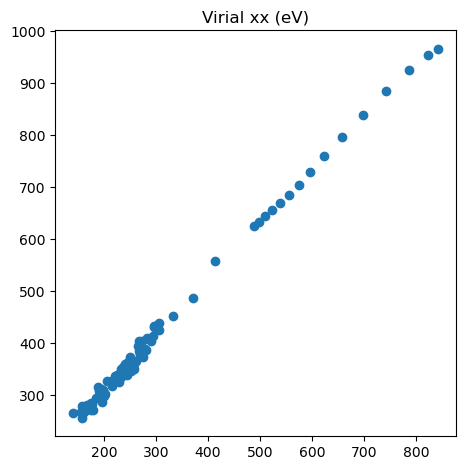

In [22]:
sigma_xx_pred=sigma_prediction[:,0,0]
sigma_xx_true=sigma_true[:,0]

import matplotlib.pyplot as plt

#VASP definition : pressure to cell, oppisite sign from stress tensor
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(sigma_xx_true, -sigma_xx_pred)
plt.title('Virial xx (eV)')
plt.tight_layout()
plt.savefig('virial_xx.png', dpi=300)

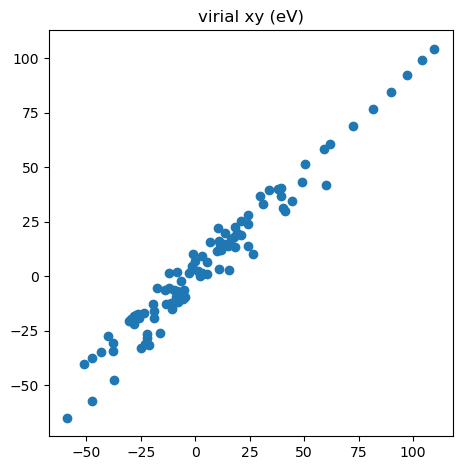

In [23]:
sigma_xy_pred=sigma_prediction[:,0,1]
sigma_xy_true=sigma_true[:,3]
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(sigma_xy_true, -sigma_xy_pred)
plt.title('virial xy (eV)')
plt.tight_layout()
plt.savefig('virial_xy.png', dpi=300)


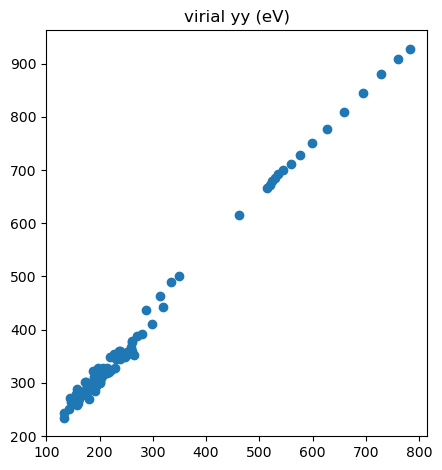

In [24]:
sigma_yy_pred=sigma_prediction[:,1,1]
sigma_yy_true=sigma_true[:,1]
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(sigma_yy_true, -sigma_yy_pred)
plt.title('virial yy (eV)')
plt.tight_layout()
plt.savefig('virial_yy.png', dpi=300)

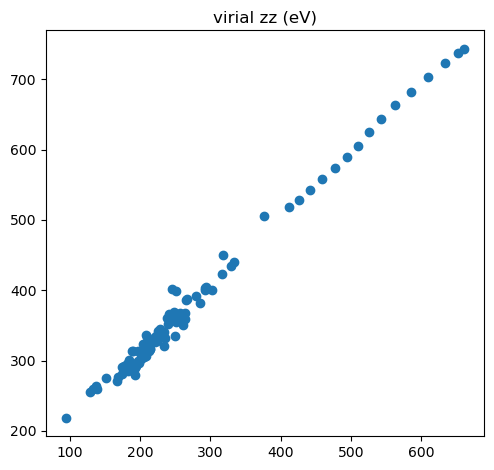

In [25]:
sigma_zz_pred=sigma_prediction[:,2,2]
sigma_zz_true=sigma_true[:,2]
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(sigma_zz_true, -sigma_zz_pred)
plt.title('virial zz (eV)')
plt.tight_layout()
plt.savefig('virial_zz.png', dpi=300)


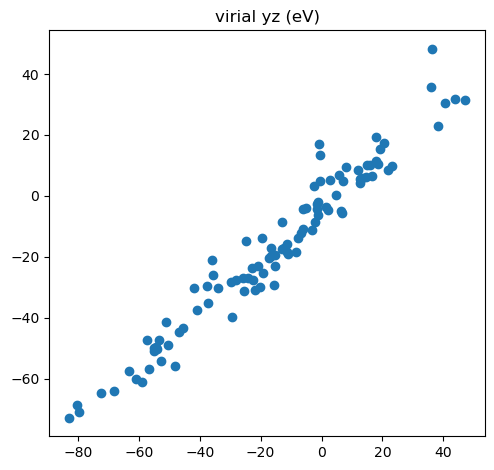

In [26]:
sigma_yz_pred=sigma_prediction[:,1,2]
sigma_yz_true=sigma_true[:,4]
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(sigma_yz_true, -sigma_yz_pred)
plt.title('virial yz (eV)')
plt.tight_layout()
plt.savefig('virial_yz.png', dpi=300)

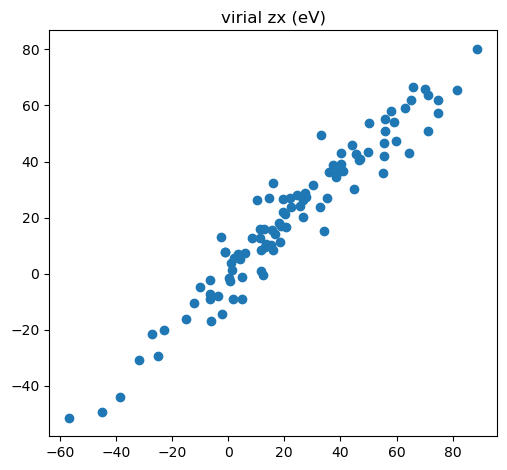

In [27]:
sigma_zx_pred=sigma_prediction[:,2,0]
sigma_zx_true=sigma_true[:,5]
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(sigma_zx_true, -sigma_zx_pred)
plt.title('virial zx (eV)')
plt.tight_layout()
plt.savefig('virial_zx.png', dpi=300)

力の予測ができている場合は、Virialもそれなりに強烈に違う値は出ていない→今の計算方法は大間違いということではなかろう

Loss functionを設計するときは符号に注意

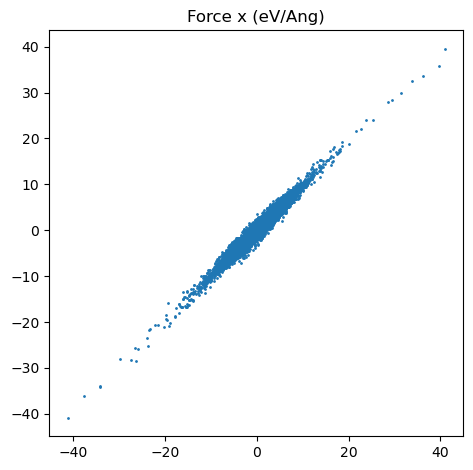

In [28]:
force_prediction=np.array(force_prediction)
force_true=np.array(force_true)
force_x_pred=force_prediction[:,:,0].flatten()
force_x_true=force_true[:,:,0].flatten()
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(force_x_true, force_x_pred, s=1)
plt.title('Force x (eV/Ang)')
plt.tight_layout()
plt.savefig('force_x.png', dpi=300)

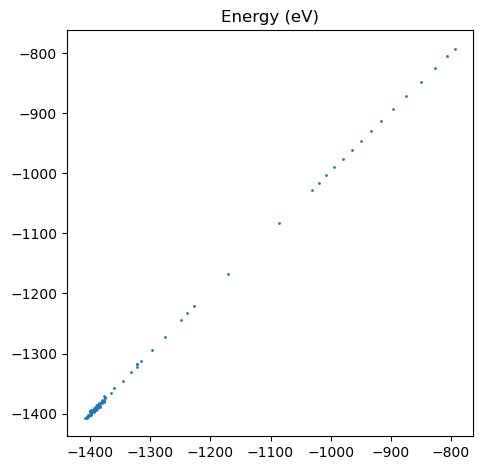

In [29]:
energy_prediction=np.array(energy_prediction)
energy_true=np.array(energy_true)
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(energy_true, energy_prediction, s=1)
plt.title('Energy (eV)')
plt.tight_layout()
plt.savefig('energy.png', dpi=300)

行列形式とs6形式の対応

In [30]:
atoms

Atoms(symbols='O140Si70', pbc=True, cell=[12.5, 12.5, 12.5], calculator=SinglePointCalculator(...))

In [31]:
atoms.info['virial_eV_s6']

array([169.67671, 158.47186, 197.66673,  59.82696,  12.6154 ,  55.60099])

In [32]:
atoms.info['virial_eV_tensor']

array([[169.67671,  59.82696,  55.60099],
       [ 59.82696, 158.47186,  12.6154 ],
       [ 55.60099,  12.6154 , 197.66673]])